In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm
from loss import CE, Align, Reconstruct
from torch.optim.lr_scheduler import LambdaLR
# from classification import fit_lr, get_rep_with_label
import os
import warnings

warnings.filterwarnings('ignore')
# from args import args, Test_data, Train_data_all, Train_data
from dataset import Dataset
from model.TimeMAE import TimeMAE
# from process import Trainer
import torch.utils.data as Data
import argparse

from datautils import load_UCR, load_txt_regress, load_txt_valid
import json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

# data = pd.read_csv('data/EFSCV/EFSCV_TRAIN.txt', sep='\t')




In [ ]:
# Train_data, Valid_data, Test_data = load_txt_regress(folder=args.UCR_folder)


# test_dataset = Dataset(device=args.device, mode='test', data=Test_data, wave_len=args.wave_length, analysis=1)
# test_loader = Data.DataLoader(test_dataset, batch_size=args.test_batch_size)

loading_data


In [ ]:
from sklearn.model_selection import train_test_split

# small = Train_data[0:100000]

train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [3]:
test_df = pd.read_csv('data/mono_full_EFSCV/mono_full_EFSCV_TEST.txt', sep='\t')
train_df = pd.read_csv('data/mono_full_EFSCV/mono_full_EFSCV_TRAIN.txt', sep='\t')

In [4]:
def load_file(data):
        
        raw_inputs = data.iloc[:, :-3].values.astype(np.float32)  # time series
        raw_labels = data.iloc[:, -2:].values.astype(np.float32)  # dopamine + serotonin
        raw_electrodes = data.iloc[:, -3] # dopamine + serotonin
        reshaped_inputs = [x.reshape(-1, 1) for x in raw_inputs]  # each: [T, 1]
        return reshaped_inputs, raw_labels, raw_electrodes

def padding_varying_length(data):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data[i, j, :][np.isnan(data[i, j, :])] = 0
    return data

TEST_DATA, TEST_LABELS, TEST_ELECTRODES = load_file(test_df)
TEST_DATA = padding_varying_length(np.array(TEST_DATA))
Test_data = [np.array(TEST_DATA), np.array(TEST_LABELS), np.array(TEST_ELECTRODES)]

In [5]:

TRAIN_DATA, TRAIN_LABELS, TRAIN_ELECTRODES = load_file(train_df)
TRAIN_DATA = padding_varying_length(np.array(TRAIN_DATA))
Train_data = [np.array(TRAIN_DATA), np.array(TRAIN_LABELS), np.array(TRAIN_ELECTRODES)]

In [6]:
filename = 'exp/mono_full_EFSCV2/test'
with open(filename + '/args.json', 'r') as file:
    args = json.load(file)

args = argparse.Namespace(**args)
train_dataset = Dataset(device=args.device, mode='pretrain', data=Train_data, wave_len=args.wave_length, analysis=1)
train_loader = Data.DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True)
test_dataset = Dataset(device=args.device, mode='test', data=Test_data, wave_len=args.wave_length, analysis=1)
test_loader = Data.DataLoader(test_dataset, batch_size=args.test_batch_size)
args.data_shape = test_dataset.shape()

model = TimeMAE(args)
state_dict = torch.load(filename + '/finetune_model_checkpoint_040.pkl', map_location='cpu')
model_state_dict = model.state_dict()
for name, param in state_dict.items():
    if name in model_state_dict:
        if param.shape == model_state_dict[name].shape:
            model_state_dict[name] = param
        else:
            print(f"Skipping {name} due to shape mismatch: {param.shape} vs {model_state_dict[name].shape}")
model.load_state_dict(model_state_dict)

313


<All keys matched successfully>

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


def get_rep_with_label(model, dataloader):
    reps = []
    labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            seq, label = batch
            seq = seq.to(args.device)
            labels += label.cpu().numpy().tolist()
            rep = model(seq)
            reps += rep.cpu().numpy().tolist()
    return reps, labels


def fit_lr(features, y):
    pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            random_state=3407,
            max_iter=1000000,
            multi_class='ovr'
        )
    )
    pipe.fit(features, y)
    return pipe
train_rep, train_label = get_rep_with_label(model, train_loader)
test_rep, test_label = get_rep_with_label(model, test_loader)

In [7]:
def get_tsne(loader, model):
    """
    Run TSNE and make dataframe
    """

    reps = []
    labels = []
    e_names = []
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(loader)):
            seqs, label, e_name = batch
            label = label.numpy()
            e_name = list(e_name)
            
            rep_batch = model(seqs)
            for i in range(len(rep_batch)):
                reps.append(rep_batch[i].numpy())
                labels.append(label[i])
                e_names.append(e_name[i])
    reps= np.array(reps)
    tsne = TSNE(n_components=2, random_state=4399)
    rep_new = tsne.fit_transform(reps)

    NeurTM= []
    labels = np.array(labels)
    for i in range(labels.shape[0]):
        if labels[i][0] > 0:
            NeurTM.append('D')
        elif labels[i][1] > 0:
            NeurTM.append('S')
        else:
            NeurTM.append('C')


    df = pd.DataFrame({
    'x': rep_new[:,0],
    'y': rep_new[:,1],
    'E_name': e_names,
    'NeurTM': NeurTM
    })
    
    return df

In [8]:
df_test = get_tsne(test_loader, model)


100%|██████████| 319/319 [09:32<00:00,  1.79s/it]


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error, r2_score

# from classification import get_rep_with_label
def get_rep_with_label(model, dataloader):
    reps = []
    labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            seq, label, _ = batch
            seq = seq.to(args.device)
            labels += label.cpu().numpy().tolist()
            rep = model(seq)
            reps += rep.cpu().numpy().tolist()
    return reps, labels

model.eval()
train_rep, train_label = get_rep_with_label(model, train_loader)  
test_rep, true_vals = get_rep_with_label(model, test_loader)
# test_rep, true_vals = get_rep_with_label(model, test_loader)
      
reg = LinearRegression().fit(train_rep, train_label)
predicted_vals = reg.predict(test_rep)
# predicted_vals = reg.predict(test_rep)
# mse = mean_squared_error(true_vals, predicted_vals)
residuals = np.array(true_vals) - np.array(predicted_vals)

# Optional: dopamine = column 0, serotonin = column 1
dopamine_pred, serotonin_pred = predicted_vals[:, 0], predicted_vals[:, 1]
dopamine_true, serotonin_true = np.array(true_vals)[:, 0], np.array(true_vals)[:,1]

residuals_dopamine = dopamine_true - dopamine_pred
residuals_serotonin = serotonin_true - serotonin_pred

100%|██████████| 319/319 [03:27<00:00,  1.54it/s]


In [10]:
df_test = pd.DataFrame({
    'x': df_test['x'],
    'y': df_test['y'],
    'dopamine_pred': dopamine_pred,
    'serotonin_pred': serotonin_pred,
    'dopamine_true': dopamine_true, 
    'serotonin_true': serotonin_true,
    'residuals_dopamine': residuals_dopamine,
    'residuals_serotonin': residuals_serotonin,
    'E_name': df_test['E_name'],
    'NeurTM': df_test['NeurTM']
})

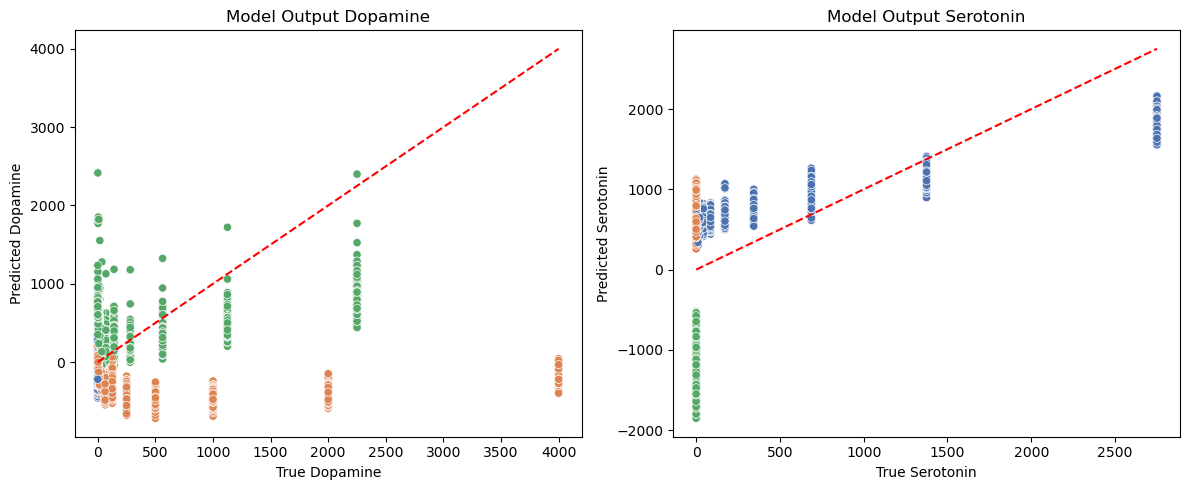

In [11]:
# Use seaborn to create scatter plot with automatic color mapping
save_dir = os.path.split(filename)[0]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_test, x='dopamine_true', y='dopamine_pred', hue='E_name', palette='deep')
plt.plot([min(dopamine_true), max(dopamine_true)], [min(dopamine_true), max(dopamine_true)], 'r--')
# plt.legend(loc= 'upper left', fontsize='8')  # ← customize here
plt.legend([],[], frameon=False)
plt.xlabel("True Dopamine")
plt.ylabel("Predicted Dopamine")
plt.title('Model Output Dopamine')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_test, x='serotonin_true', y='serotonin_pred', hue='E_name', palette='deep', legend = False)
plt.plot([min(serotonin_true), max(serotonin_true)], [min(serotonin_true), max(serotonin_true)], 'r--')
plt.xlabel("True Serotonin")
plt.ylabel("Predicted Serotonin")
plt.title('Model Output Serotonin')

plt.tight_layout()
# plt.savefig(save_dir + "/Pred_vs_True_Valid.png")
plt.show()

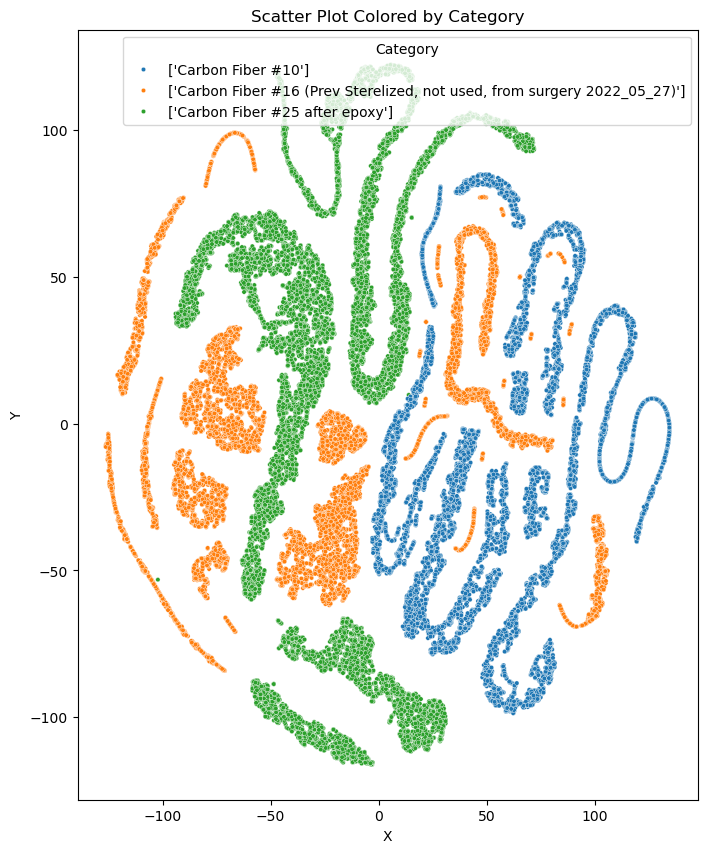

In [15]:
# Use seaborn to create scatter plot with automatic color mapping
plt.figure(figsize=(8, 10))
sns.scatterplot(data=df_test, x='x', y='y', hue='E_name', s=10)

plt.title('Scatter Plot Colored by Category')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(title='Category')
plt.show()

In [16]:
reps = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        seq, label, _ = batch
        seq = seq.to(args.device)
        labels += label.cpu().numpy().tolist()
        rep = model(seq)
        reps += rep.cpu().numpy().tolist()


100%|██████████| 319/319 [03:32<00:00,  1.50it/s]


In [42]:
i = iter(train_loader)
batch=next(i)

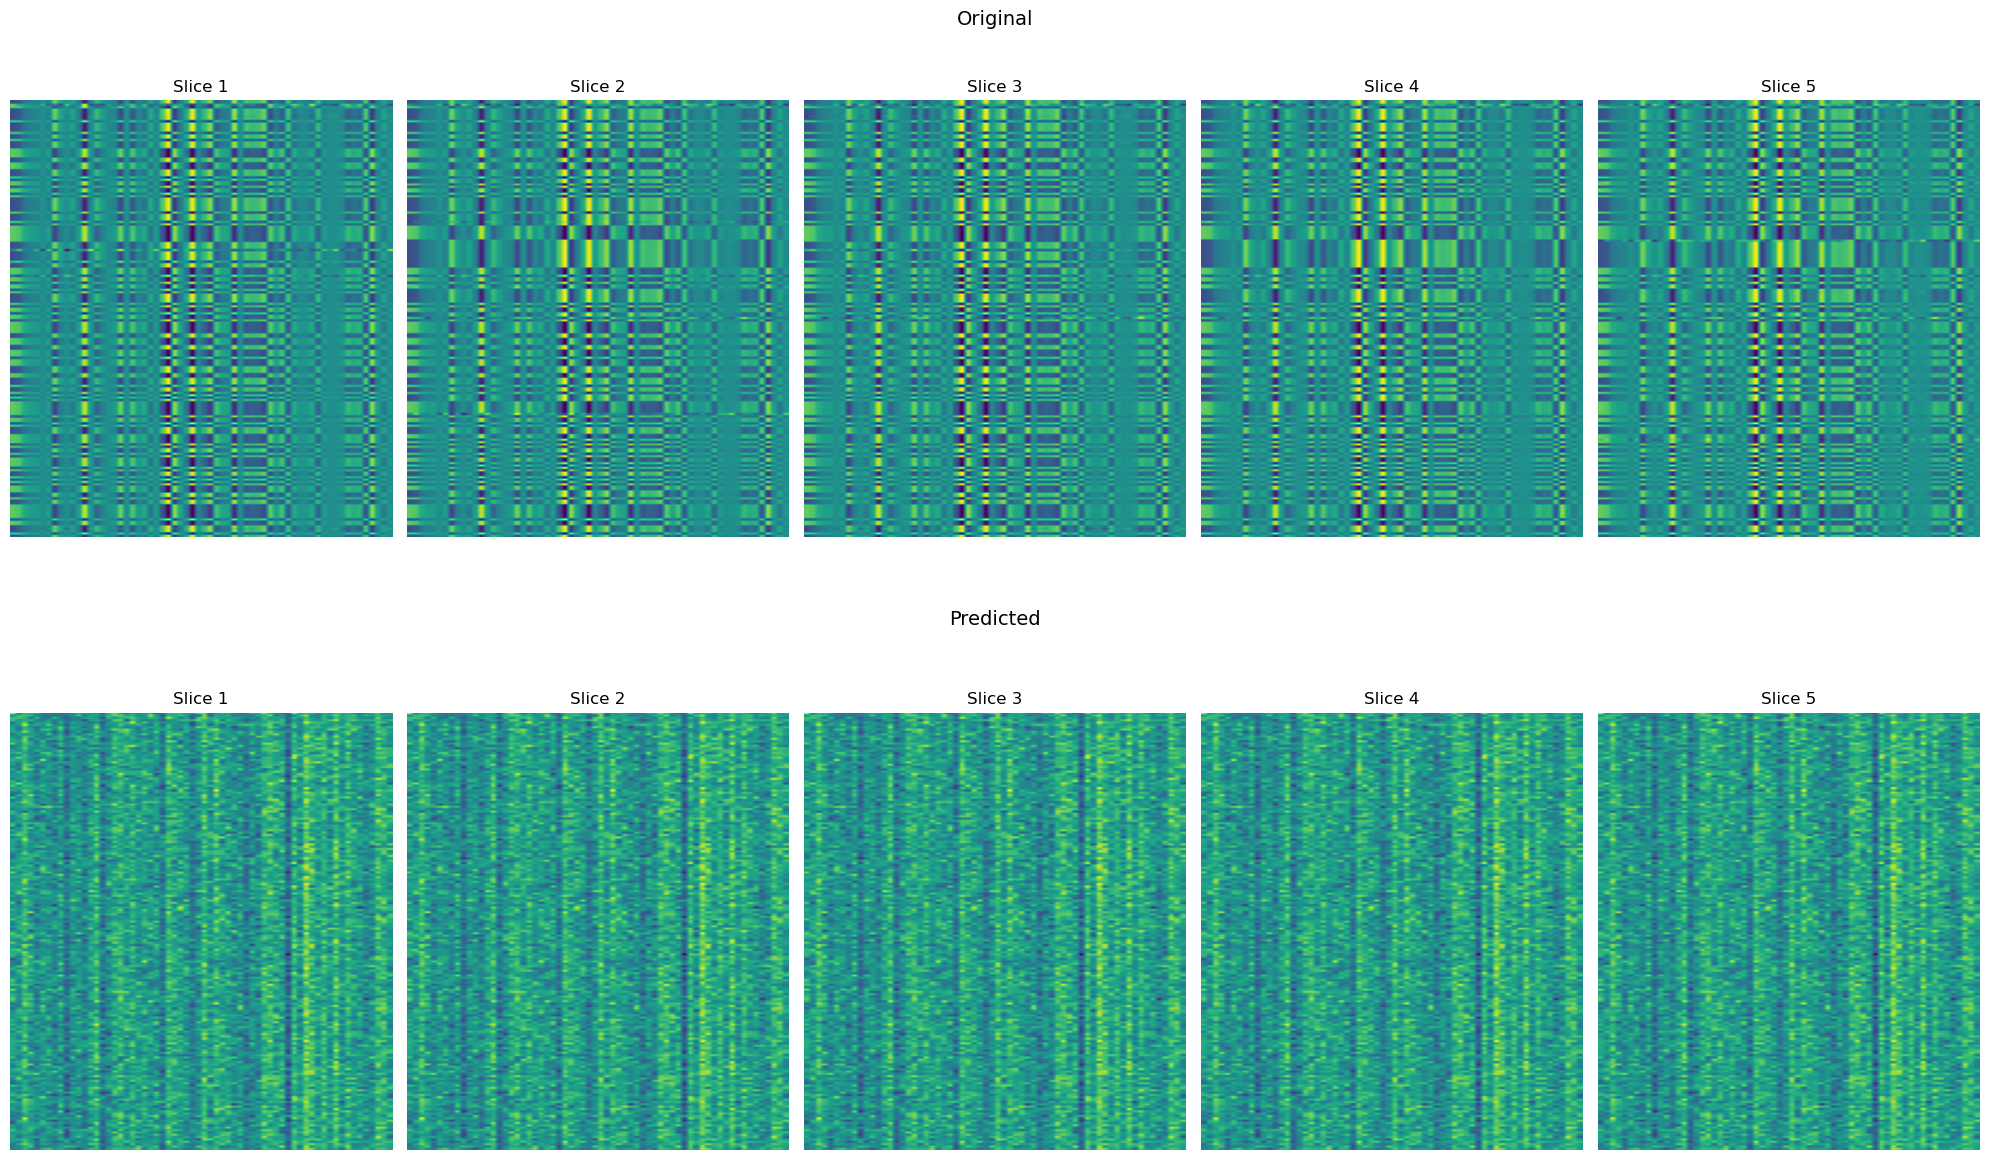

In [48]:
[rep_mask, rep_mask_prediction], [token_prediction_prob, tokens] = model.pretrain_forward(batch[0])
rmp=rep_mask_prediction.detach().numpy() 
# Plotting the first 5 slices for demonstration (you can adjust this)
fig, axs = plt.subplots(2, 5, figsize=(20, 15))

# Show the first 5 slices as images
for i in range(5):
    axs[0,i].imshow(rep_mask[i+10], cmap='viridis', aspect='auto')
    axs[0,i].set_title(f"Slice {i+1}")
    axs[0,i].axis('off')  # Hide axes
    axs[1,i].imshow(rmp[i+10], cmap='viridis', aspect='auto')
    axs[1,i].set_title(f"Slice {i+1}")
    axs[1,i].axis('off')  # Hide axes
fig.text(0.5, 1, 'Original', ha='center', fontsize=14)
fig.text(0.5, 0.6, 'Predicted', ha='center', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.25, hspace=0.4)  # Adjust hspace to add space between rows

plt.show()

In [47]:
token_prediction_prob.detach().numpy()
    
# tokens.detach().numpy()

array([[[ 0.926745  , -0.19549674,  0.20481154, ..., -1.2396826 ,
          0.26336107, -0.09480388],
        [ 0.40764898,  0.33310935, -1.1297644 , ...,  0.7553414 ,
          0.11490991,  0.8300528 ],
        [ 0.7587552 ,  0.46550354,  0.6235912 , ..., -0.5490784 ,
          0.3994891 , -1.5653452 ],
        ...,
        [ 0.89579195,  1.0383197 ,  0.21293396, ...,  0.53050244,
         -0.0842371 , -0.5601739 ],
        [ 0.13310641,  0.27033776,  0.23063248, ...,  0.1344627 ,
         -0.01885879, -0.72608393],
        [ 0.16012922,  0.3813457 ,  0.5658728 , ..., -0.38263795,
         -0.5088651 ,  0.25133952]],

       [[ 0.926745  , -0.19549674,  0.20481154, ..., -1.2396826 ,
          0.26336107, -0.09480388],
        [ 0.40764898,  0.33310935, -1.1297644 , ...,  0.7553414 ,
          0.11490991,  0.8300528 ],
        [ 0.7587552 ,  0.46550354,  0.6235912 , ..., -0.5490784 ,
          0.3994891 , -1.5653452 ],
        ...,
        [ 0.89579195,  1.0383197 ,  0.21293396, ...,  